<a href="https://colab.research.google.com/github/twyeh/solid-state-physics/blob/main/01_atoms_and_calculators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 76.6 MB/s eta 0:00:00



# Atoms and calculators

ASE allows atomistic calculations to be scripted with different
computational codes. In this introductory exercise, we go through the
basic concepts and workflow of ASE and will eventually
calculate the binding curve of :mol:`N_2`.


## Python

In ASE, calculations are performed by writing and running Python
scripts.  A very short primer on Python can be found in the
`ASE documentation <what is python>`.
If you are new to Python it would be wise to look through
this to understand the basic syntax, datatypes, and
things like imports.  Or you can just wing it --- we won't judge.


## Atoms

Let's set up a molecule and run a calculation.
We can create
simple molecules by manually typing the chemical symbols and a
guess for the atomic positions in Ångström.  For example
:mol:`N_2`:


In [4]:
from ase import Atoms

atoms = Atoms('N2', positions=[[0, 0, -1], [0, 0, 1]])

Just in case we made a mistake, we should visualize our molecule
using the :mod:`ASE GUI <ase.gui>`:




```python
from ase.visualize import view
view(atoms)
```
Equivalently we can save the atoms in some format, often ASE's own
:mod:`~ase.io.trajectory` format:




In [5]:
from ase.io import write

write('myatoms.traj', atoms)

Then run the GUI from a terminal::

 $ ase gui myatoms.traj

ASE supports quite a few different formats.   For the full list, run::

 $ ase info --formats

Although we won't be using all the ASE commands any time soon,
feel free to get an overview::

 $ ase --help


## Calculators

Next, let us perform a calculation.  ASE uses
:mod:`~ase.calculators` to perform calculations. Calculators are
abstract interfaces to different backends which do the actual computation.
Normally, calculators work by calling an external electronic structure
code or force field code.  To run a calculation, we must first create a
calculator and then attach it to the :class:`~ase.Atoms` object.
For demonstration purposes, we use the :class:`~ase.calculators.emt.EMT`
calculator which is implemented in ASE.
However, there are many other internal and external
calculators to choose from (see :mod:`~ase.calculators`).




In [6]:
from ase.calculators.emt import EMT

calc = EMT()
atoms.calc = calc

Once the :class:`~ase.Atoms` object have a calculator with appropriate
parameters, we can do things like calculating energies and forces:




In [7]:
e = atoms.get_potential_energy()
print('Energy', e)
f = atoms.get_forces()
print('Forces', f)

Energy 6.1239042559302534
Forces [[ 0.          0.          5.36544175]
 [ 0.          0.         -5.36544175]]


This will give us the energy in eV and the forces in eV/Å
(see :mod:`~ase.units` for the standard units ASE uses).

Depending on the calculator, other properties are also available to calculate.
For this check the documentation of the respective calculator
or print the implemented properties the following way:



In [8]:
print(EMT.implemented_properties)

['energy', 'free_energy', 'energies', 'forces', 'stress', 'magmom', 'magmoms']


## Binding curve of :mol:`N_2`

The strong point of ASE is that things are scriptable.
``atoms.positions`` is a numpy array containing the atomic positions:




In [9]:
print(atoms.positions)

[[ 0.  0. -1.]
 [ 0.  0.  1.]]


We can move the nitrogen atoms by adding or assigning other values into some
of the array elements.  ASE understands that the state of the atoms object has
changed and therefore we can trigger a new calculation by calling
:meth:`~ase.Atoms.get_potential_energy` or :meth:`~ase.Atoms.get_forces`
again, without reattatching a calculator.




In [10]:
atoms.positions[0, 2] += 0.1  # z-coordinate change of atom 0
e = atoms.get_potential_energy()
print('Energy', e)
f = atoms.get_forces()
print('Forces', f)

Energy 5.561108500221476
Forces [[ 0.          0.          5.88823349]
 [ 0.          0.         -5.88823349]]


This way we can implement any series of calculations by changing the atoms
object and subsequently calculating a property.  When running
multiple calculations, we often want to write them into a file.
We can use the standard :mod:`~ase.io.trajectory` format to write multiple
calculations in which the atoms objects and their respective properties
such as energy and forces are contained. Here for a single
calculation:




In [11]:
from ase.io.trajectory import Trajectory

with Trajectory('mytrajectory.traj', 'w') as traj:
    traj.write(atoms)

Now, we can displace one of the atoms in small steps to trace out a binding
energy curve $E(d)$ around the equilibrium
distance.  We safe each step to a single trajectory file so that we can
evaluate the results later on separately.




In [12]:
atoms = Atoms('N2', positions=[[0, 0, -1], [0, 0, 1]])

calc = EMT()
atoms.calc = calc

step = 0.1
nsteps = int(6 / step)

with Trajectory('binding_curve.traj', 'w') as traj:
    for i in range(nsteps):
        d = 0.5 + i * step
        atoms.positions[1, 2] = atoms.positions[0, 2] + d

        e = atoms.get_potential_energy()
        f = atoms.get_forces()
        print('distance, energy', d, e)
        print('force', f)
        traj.write(atoms)

distance, energy 0.5 9.870758556485448
force [[  0.           0.         -52.28823918]
 [  0.           0.          52.28823918]]
distance, energy 0.6 5.5891182020987875
force [[  0.           0.         -34.25676672]
 [  0.           0.          34.25676672]]
distance, energy 0.7 2.8596713200020494
force [[  0.           0.         -21.02820162]
 [  0.           0.          21.02820162]]
distance, energy 0.8 1.2619022218412255
force [[  0.           0.         -11.45544942]
 [  0.           0.          11.45544942]]
distance, energy 0.9 0.47657850003904656
force [[ 0.          0.         -4.64947593]
 [ 0.          0.          4.64947593]]
distance, energy 1.0 0.262852687667797
force [[ 0.          0.          0.07663707]
 [ 0.          0.         -0.07663707]]
distance, energy 1.1 0.440343573035614
force [[ 0.          0.          3.25179997]
 [ 0.          0.         -3.25179997]]
distance, energy 1.2000000000000002 0.8751414634853774
force [[ 0.        0.        5.281651]
 [ 0.    

As before, you can use the command line interface to visualize
the dissociation process::

 $ ase gui binding_curve.traj

Although the GUI will plot the energy curve for us, publication
quality plots usually require some manual tinkering.
ASE provides two functions to read trajectories or other files:

 * :func:`ase.io.read` reads and returns the last image, or possibly a
   list of images if the ``index`` keyword is also specified.

 * :func:`ase.io.iread` reads multiple images, one at a time.

Use :func:`ase.io.iread` to read the images back in, e.g.:




In [13]:
from ase.io import iread

for atoms in iread('binding_curve.traj'):
    print(atoms.get_potential_energy())

9.870758556485448
5.5891182020987875
2.8596713200020494
1.2619022218412255
0.47657850003904656
0.262852687667797
0.440343573035614
0.8751414634853774
1.4689017306321919
2.1503656496757095
2.8687861585156504
3.588846100007662
4.286743654814872
4.947188703592237
5.561108500221475
6.1239042559302534
6.634134384874031
7.092527120173083
7.501246466384996
7.863352195013119
8.18240775547698
8.46220031276367
8.706545228262538
8.919153642872061
9.103546774571704
9.263004401897888
9.40053800411676
9.518881353341813
9.620493149523368
9.707567671426157
9.782050476255852
9.845656988982057
9.899892435802158
9.946072038657272
9.985340733744675
10.018691933526325
10.046985039824794
10.070961551568727
10.091259707272991
10.108427669212126
10.122935301026965
10.135184619084068
10.14551901563504
10.154231370550555
10.16157126835245
10.16775243017553
10.172969623589921
10.177507006847515
10.18252838152903
10.191037181243342
10.197610791147888
10.199490793232709
10.199895789175132
10.199978991085064
10.2
1

Now, we can plot the binding curve (energy as a function of distance)
with matplotlib and calculate the dissociation energy.
We first collect the energies and the distances when looping
over the trajectory.  The atoms already have the energy.  Hence, calling
``atoms.get_potential_energy()`` will simply retrieve the energy
without calculating anything.




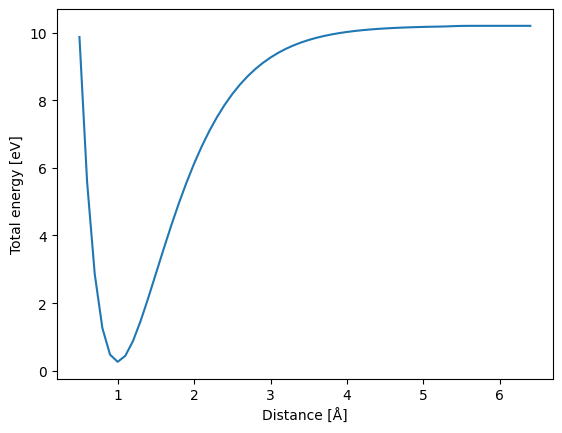

Dissociation energy [eV]:  9.937147312332202


In [14]:
import matplotlib.pyplot as plt

energies = []
distances = []

for atoms in iread('binding_curve.traj'):
    energies.append(atoms.get_potential_energy())
    distances.append(atoms.positions[1, 2] - atoms.positions[0, 2])

ax = plt.gca()
ax.plot(distances, energies)
ax.set_xlabel('Distance [Å]')
ax.set_ylabel('Total energy [eV]')
plt.show()

print('Dissociation energy [eV]: ', energies[-1] - min(energies))